In [1]:
import glob
import ROOT
import LIGO_style
from astropy.time import Time
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from proc_utils import *

Welcome to JupyROOT 6.24/06


In [2]:
# Download data from: https://www.gw-openscience.org/archive/O1/
fs = glob.glob('data/O1/test/H-H1_LOSC_4_V1-1126256640-4096.gwf')

f = fs[-1]
kdq, kinj, kdata = get_channel_names(f)

# 7s window around GW150914
sgfirst = 1126259462-2+0.23
tmin = sgfirst
deltat = 4+3
tmax = tmin + deltat

# 32s window around GW150914
#tmin = 1126259446
#tmax = tmin + 32

#series = TimeSeries.read(f, kdata)
data = TimeSeries.read(f, kdata, start=tmin, end=tmax)
#data = TimeSeries.fetch_open_data('H1', tmin, tmax) # download data in-place

Loading: FrSerData
Loading: FrSerData::n4294967295
Loading: FrSummary
Loading: FrSummary::n4294967295
Loading: FrSerData
Loading: FrSerData::n4294967295
Loading: FrSummary
Loading: FrSummary::n4294967295


In [3]:
# Process strain: calib BP, whiten, analysis BP
# see proc_utils.py:process_strain()
strain = process_strain(data, t_trunc=2) # truncate 2s from whitened strain to avoid corrupted edges

# zoom in on main inspiral
t_window = 1024*strain.dt.value # use even multiple of 1/(sampling freq = 4kHz): 0.25 s
t_start = strain.t0.value
t_end = t_start+t_window#+strain.dt.value
print('Croping: [%f, %f) = %f s'%(t_start, t_end, t_end-t_start))
gw = strain.crop(t_start, t_end) # [t_start, t_end)

Croping: [1126259462.229980, 1126259462.479980) = 0.250000 s


In [4]:
# Plot using gwpy matplotlib wrapper
plot_series(gw)

In [5]:
# Get times, in s
times = gw.times.value # numpy array of time edges
print(len(times))
# NOTE: t_start will be included but t_end will be excluded
print(times[0], times[-1])
# Get time duration, in s
# This will be over full interval [t_start, t_end)
t_total = gw.duration.value
print(t_total)

# Get amplitudes, in whitened strain
amps = gw.value # numpy array of amplitdues between time edges
print(len(amps))

1024
1126259462.2299805 1126259462.4797363
0.25
1024


In [6]:
# Style options for LIGO_style (based on CMS_style)

def set_hist(h, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.16)
    #c.SetRightMargin(0.15)
    #c.SetBottomMargin(0.13)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    h.GetXaxis().SetLabelFont(42)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.09)
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetTitleFont(42)

    h.GetYaxis().SetLabelSize(0.04)
    h.GetYaxis().SetLabelFont(42)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleFont(42)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    h.SetTitleFont(42)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    #return h, c
    return h

ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
LIGO_style.writeExtraText = 1
LIGO_style.extraText = "Hanford" # H1
LIGO_style.cmsTextOffset = 0.
t_total_s = t_total # s
t_total_str = '%ss'%(t_total_s)
LIGO_style.lumi_sqrtS = "%s (O1)"%t_total_str # display waveform duration
LIGO_style.lumi_sqrtS = "%f GPST (O1)"%t_start # display waveform GPS start time
LIGO_style.lumi_sqrtS = "%s UTC (O1)"%Time(Time(t_start, format='gps'), format='iso', scale='utc') # display waveform UTC start time

#iPos = 11 # inside frame
iPos = 0 # above frame
iPeriod = 0

2015-09-14 09:50:45.230 UTC (O1)


Info in <TCanvas::Print>: pdf file gw.pdf has been created


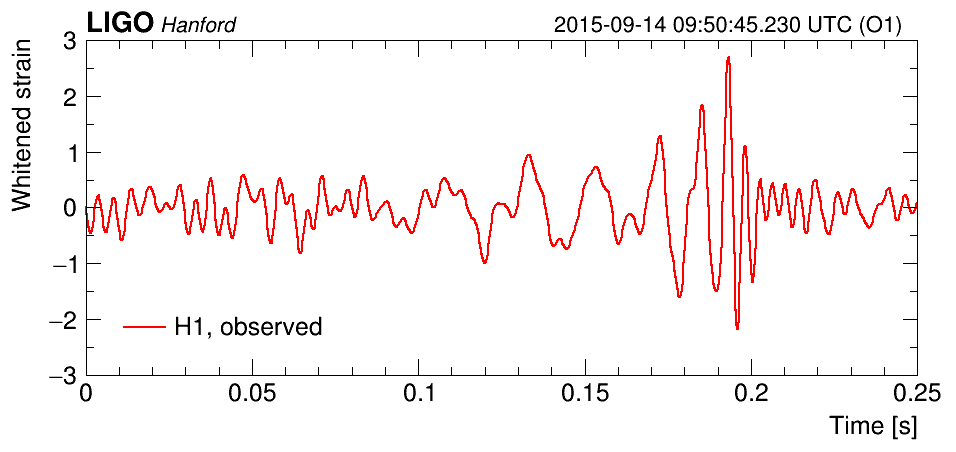

In [7]:
h, c, legend = {}, {}, {}

k = 'gw'
c[k] = ROOT.TCanvas(k, k, 960, 480)
h[k] = ROOT.TH1F(k, k, len(amps), 0., t_total)


for ib in range(1, h[k].GetNbinsX()+1):
    h[k].SetBinContent(ib, amps[ib-1])

h[k] = set_hist(h[k], 'Time [s]', 'Whitened strain', '')

ROOT.gPad.SetTopMargin(0.09)
ROOT.gPad.SetBottomMargin(0.17)
ROOT.gPad.SetLeftMargin(0.09)
ROOT.gPad.SetRightMargin(0.04)
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetErrorX(0.)
#ROOT.gPad.SetLogx()
#ROOT.gPad.SetLogy()

ymin, ymax = -3., 3.
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(0.7)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetLabelOffset(0.01)
h[k].GetYaxis().SetLabelSize(0.06)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTickLength(0.02)
h[k].GetYaxis().SetNdivisions(408)
#h[k].GetYaxis().SetNdivisions(404)
#h[k].GetYaxis().SetMaxDigits(3)

h[k].GetXaxis().SetTitleOffset(1.2)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetLabelOffset(0.01)
h[k].GetXaxis().SetLabelSize(0.06)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTickLength(0.04)
h[k].GetXaxis().SetNdivisions(508)

# Line options
h[k].SetLineColor(2)
h[k].SetLineWidth(2)
h[k].Draw('hist')

legend[k] = ROOT.TLegend(0.12, 0.2, 0.12+0.25, 0.2+0.15) #(x1, y1, x2, y2)
legend[k].AddEntry(h[k].GetName(), "H1, observed", "l")
legend[k].SetBorderSize(0)
legend[k].SetTextFont(42)
legend[k].Draw("same")

#c[k].SetGridx(1)
#c[k].SetGridy(1)
c[k].RedrawAxis()
c[k].Draw()

LIGO_style.relPosX = 0.09
LIGO_style.LIGO_style(c[k], iPeriod, iPos)

c[k].Print('gw.pdf')